## Method 2: SVM 

### Read data and create plotting confusion matrix, ROC curve, and PR curve functions

In [13]:
# import necessary toolbox
import numpy as np
import pandas as pd
import pickle
import itertools
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
# read in our data which was previous splited into training and testing data set
with open('xtrain_doodle.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open('xtest_doodle.pickle', 'rb') as f:
    X_test = pickle.load(f)

with open('ytrain_doodle.pickle', 'rb') as f:
    y_train = pickle.load(f)

with open('ytest_doodle.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [3]:
y_train_binary = label_binarize(y_train, list(range(10)))
y_test_binary = label_binarize(y_test, list(range(10)))

In [4]:
class_names = np.array(['mouse','ant','bear','bee','sea turtle','cat','crab','dragon','elephant','snail'])

#### Confusion matrix

In [5]:
 #define a function which plots the confusion matrix---new version
# this function can show both non-normalized and normalized confusion matrix and specific number in the plot
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### ROC curve

In [6]:
# define a function so that we can draw ROC curves in multi-class setting
def plot_multiclass_roc(y_test, y_score, n_classes, kernal):
    # Compute ROC curve and ROC aera for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i],_ = roc_curve(y_test[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute the micro-average ROC curve and ROC aera
    fpr["micro"], tpr["micro"],_ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC aera
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i],tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label = 'micro-vaerage ROC curve (aera = {0:0.2f})'
             ''.format(roc_auc["micro"]), 
             color = "deeppink", linestyle = ":", linewidth = 4)
    plt.plot(fpr["macro"], tpr["macro"], label = 'macro-vaerage ROC curve (aera = {0:0.2f})'
             ''.format(roc_auc["macro"]), 
             color = "navy", linestyle = ":", linewidth = 4)
    colors = cycle(['aqua','brown','cyan','darkgreen','firebrick','gray','hotpink','ivory','khaki','lightsalmon'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],tpr[i],color = color, lw = lw,
                label = "ROC curve of class {0} (aera = {1:0.2f})" "".format(i,roc_auc[i]))
    plt.plot([0,1], [0,1], "k--", lw=lw)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multi-class (kernal: " + kernal + ")")
    plt.legend(loc = "lower right")
    plt.show()    

#### PR curve

In [7]:
# define a function so that we can draw PR curves in multi-class setting
def plot_multiclass_pr(y_test, y_score, n_classes, kernal):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i],_ = precision_recall_curve(y_test[:,i], y_score[:,i])
        average_precision[i] = average_precision_score(y_test[:,i],y_score[:,i])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"],_ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average = "micro")
    
    #setup plot details
    colors = cycle(['aqua','brown','cyan','darkgreen','firebrick','gray','hotpink','ivory','khaki','lightsalmon'])
    plt.figure(figsize=(10,12))
    f_scores = np.linspace(0.2,0.8, num = 4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01,1)
        y = f_score * x/(2*x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color = 'black', alpha = 0.2)
        plt.annotate('f1 = {0:0.1f}'.format(f_score),xy = (0.9, y[45] + 0.02))
        
    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color = 'gold', lw = 2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})' 
                  ''.format(average_precision['micro']))
    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color = color, lw = 2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                     ''.format(i,average_precision[i]))
        
    fig = plt.gcf()
    fig.subplots_adjust(bottom = 0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multiclass (kernal: ' + kernal + ')')
    plt.legend(lines, labels, loc = (0, 0), prop = dict(size = 14))
    plt.show()

### Linear kernal

In [8]:
# fit the model with C = 1, kernel = linear
svm_model = svm.SVC(kernel = 'linear',C = 1,verbose = 2)
svm_model.fit(X_train,y_train)
yhat_svm = svm_model.predict(X_test)
y_score = svm_model.decision_function(X_test)
# print the result
print("Classification report for classifier %s:\n%s\n"
      % (svm_model, metrics.classification_report(y_test, yhat_svm)))
confusion_matrix = metrics.confusion_matrix(y_test, yhat_svm)
print("Accuracy={}".format(metrics.accuracy_score(y_test, yhat_svm)))

[LibSVM]Classification report for classifier SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=2):
             precision    recall  f1-score   support

        0.0       0.36      0.42      0.38       645
        1.0       0.45      0.51      0.48       611
        2.0       0.47      0.54      0.51       615
        3.0       0.50      0.41      0.45       594
        4.0       0.48      0.53      0.50       565
        5.0       0.29      0.26      0.28       582
        6.0       0.44      0.39      0.42       616
        7.0       0.58      0.53      0.56       593
        8.0       0.36      0.35      0.35       559
        9.0       0.54      0.51      0.52       620

avg / total       0.45      0.45      0.44      6000


Accuracy=0.44533333333333336


Confusion matrix, without normalization
[[270  24  40  27  45 102  44  36  26  31]
 [ 32 309  37  45  26  21  43  43  38  17]
 [ 50  22 335  30  14  33  18   6  36  71]
 [ 45  55  45 241  64  30  21  16  45  32]
 [ 58  31  20  33 300  46  13  15  35  14]
 [106  41  41  29  64 154  36  29  53  29]
 [ 51  58  34  17  22  62 241  31  60  40]
 [ 60  66  11  19  33  24  26 315  24  15]
 [ 39  63  72  23  45  35  40  30 193  19]
 [ 49  15  75  21  15  28  60  18  25 314]]
Normalized confusion matrix
[[0.42 0.04 0.06 0.04 0.07 0.16 0.07 0.06 0.04 0.05]
 [0.05 0.51 0.06 0.07 0.04 0.03 0.07 0.07 0.06 0.03]
 [0.08 0.04 0.54 0.05 0.02 0.05 0.03 0.01 0.06 0.12]
 [0.08 0.09 0.08 0.41 0.11 0.05 0.04 0.03 0.08 0.05]
 [0.1  0.05 0.04 0.06 0.53 0.08 0.02 0.03 0.06 0.02]
 [0.18 0.07 0.07 0.05 0.11 0.26 0.06 0.05 0.09 0.05]
 [0.08 0.09 0.06 0.03 0.04 0.1  0.39 0.05 0.1  0.06]
 [0.1  0.11 0.02 0.03 0.06 0.04 0.04 0.53 0.04 0.03]
 [0.07 0.11 0.13 0.04 0.08 0.06 0.07 0.05 0.35 0.03]
 [0.08 0.02 0.12 0.03 0.

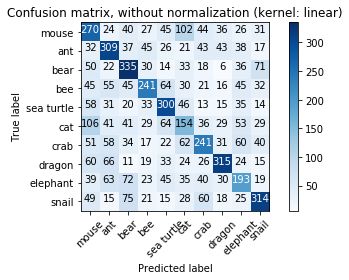

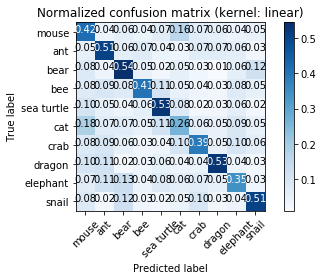

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization (kernel: linear)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (kernel: linear)')

plt.show()

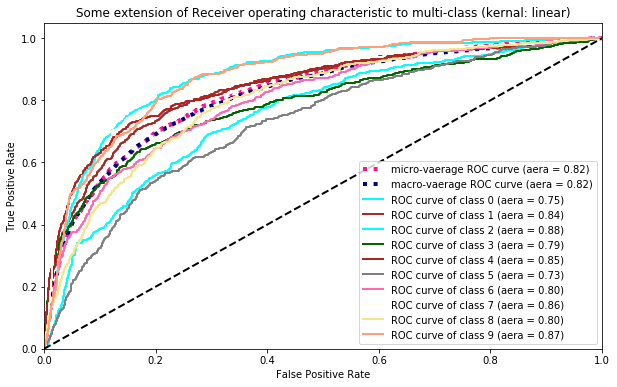

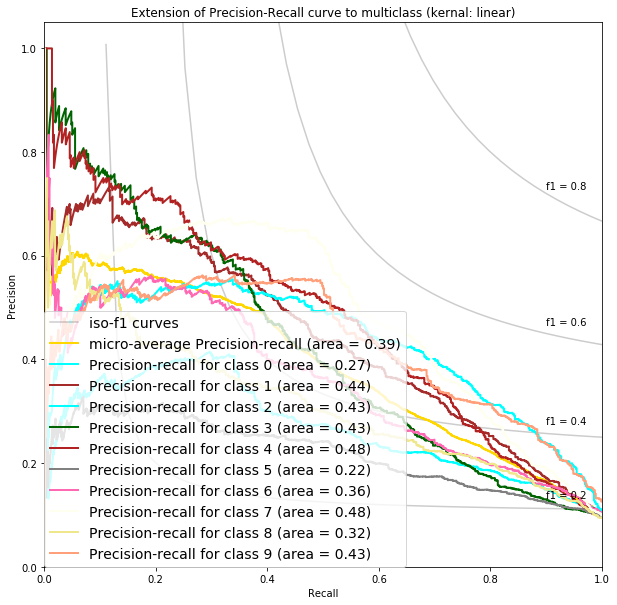

In [27]:
# plot ROC curve
plot_multiclass_roc(y_test_binary, y_score,10,'linear')

# plot PR curve
plot_multiclass_pr(y_test_binary,y_score,10,'linear')

### Polynomial kernel

#### Grid Search with Cross Validation

In [16]:
# generate parameter space of C and Gamma
Gamma = np.array([0.001,0.01,0.1,1,10,100]) 
C = np.array([0.001,0.01,0.1,1,10,100]) 

# grid search with cross validation where cv=3 
parameters = {'kernel':['poly'], 'C':C, 'gamma': Gamma}
svm = svm.SVC()
gridsearch = GridSearchCV(estimator=svm,param_grid=parameters,n_jobs=1, verbose=2)
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_

In [18]:
print("Parameters:{}".format(parameters))
print("Best parameters:{}".format(best_params))

Parameters:{'kernel': ['poly'], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}
Best parameters:{'kernel': ['poly'], 'C': 10, 'gamma': 0.05}


#### Use best parameters to fit the model and show the results  (confusion matrix and classification report)

In [8]:
# fit the model with C = 100, gamma = 0.05
svm_model1 = svm.SVC(kernel = 'poly',C = 10,gamma = 0.05)
svm_model1.fit(X_train,y_train)
yhat_svm1 = svm_model1.predict(X_test)
y_score1 = svm_model1.decision_function(X_test)

In [9]:
# print the result
print("Classification report for classifier %s:\n%s\n"
      % (svm_model1, metrics.classification_report(y_test, yhat_svm1)))
print("Accuracy={}".format(metrics.accuracy_score(y_test, yhat_svm1)))

Classification report for classifier SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.64      0.67      0.65       645
        1.0       0.56      0.63      0.59       611
        2.0       0.68      0.69      0.69       615
        3.0       0.70      0.62      0.66       594
        4.0       0.69      0.68      0.69       565
        5.0       0.53      0.50      0.51       582
        6.0       0.66      0.60      0.63       616
        7.0       0.62      0.69      0.65       593
        8.0       0.60      0.59      0.60       559
        9.0       0.84      0.81      0.82       620

avg / total       0.65      0.65      0.65      6000


Accuracy=0.6501666666666667


Confusion matrix, without normalization
[[435   8  31  10  14  44  26  45  23   9]
 [ 21 385  17  32  12  22  34  59  25   4]
 [ 34  25 427  17   7  27  15  12  28  23]
 [ 21  52  23 368  38  32  12  22  16  10]
 [ 33  15   7  22 385  25  16  14  45   3]
 [ 37  43  31  24  42 290  35  38  30  12]
 [ 30  60  22  18  14  40 370  27  27   8]
 [ 38  48   8  18   7  17  19 409  14  15]
 [ 21  41  43   8  32  34  18  20 332  10]
 [ 15  11  22  11   3  17  16  15  10 500]]
Normalized confusion matrix
[[0.67 0.01 0.05 0.02 0.02 0.07 0.04 0.07 0.04 0.01]
 [0.03 0.63 0.03 0.05 0.02 0.04 0.06 0.1  0.04 0.01]
 [0.06 0.04 0.69 0.03 0.01 0.04 0.02 0.02 0.05 0.04]
 [0.04 0.09 0.04 0.62 0.06 0.05 0.02 0.04 0.03 0.02]
 [0.06 0.03 0.01 0.04 0.68 0.04 0.03 0.02 0.08 0.01]
 [0.06 0.07 0.05 0.04 0.07 0.5  0.06 0.07 0.05 0.02]
 [0.05 0.1  0.04 0.03 0.02 0.06 0.6  0.04 0.04 0.01]
 [0.06 0.08 0.01 0.03 0.01 0.03 0.03 0.69 0.02 0.03]
 [0.04 0.07 0.08 0.01 0.06 0.06 0.03 0.04 0.59 0.02]
 [0.02 0.02 0.04 0.02 0.

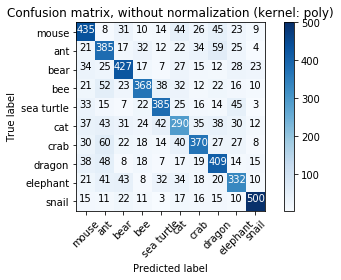

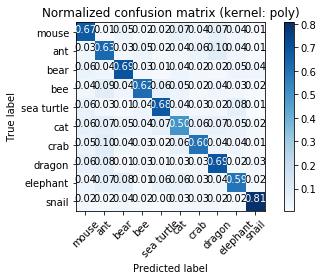

In [10]:
# Compute confusion matrix
cnf_matrix1 = confusion_matrix(y_test, yhat_svm1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names,
                      title='Confusion matrix, without normalization (kernel: poly)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (kernel: poly)')

plt.show()

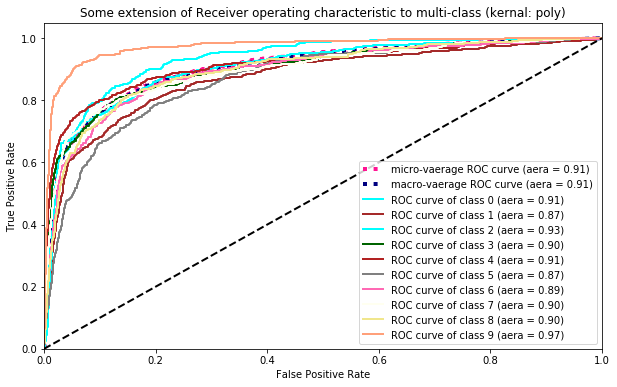

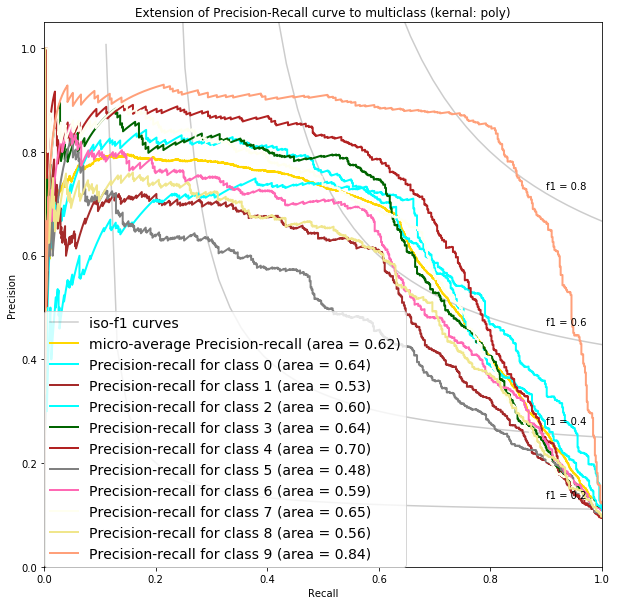

In [11]:
# plot ROC curve
plot_multiclass_roc(y_test_binary, y_score1,10,'poly')

# plot PR curve
plot_multiclass_pr(y_test_binary,y_score1,10,'poly')

### Gaussian kernel

In [28]:
# fit the model with C = 10, gamma = 0.05
svm_model2 = svm.SVC(kernel = 'rbf',C = 10,gamma = 0.05)
svm_model2.fit(X_train,y_train)
yhat_svm2 = svm_model2.predict(X_test)
y_score2 = svm_model2.decision_function(X_test)

In [29]:
# print the result
print("Classification report for classifier %s:\n%s\n"
      % (svm_model2, metrics.classification_report(y_test, yhat_svm2)))
print("Accuracy={}".format(metrics.accuracy_score(y_test, yhat_svm2)))

Classification report for classifier SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.69      0.54      0.61       645
        1.0       0.45      0.69      0.54       611
        2.0       0.53      0.75      0.62       615
        3.0       0.55      0.58      0.57       594
        4.0       0.69      0.59      0.64       565
        5.0       0.52      0.43      0.47       582
        6.0       0.61      0.56      0.58       616
        7.0       0.73      0.61      0.66       593
        8.0       0.60      0.50      0.55       559
        9.0       0.77      0.72      0.75       620

avg / total       0.61      0.60      0.60      6000


Accuracy=0.5978333333333333


Confusion matrix, without normalization
[[349  29  71  23  18  44  55  28  15  13]
 [ 13 421  30  44   6  11  35  25  22   4]
 [ 15  26 459  25   1  23  11   5  17  33]
 [ 18  71  42 345  37  25  10  14  11  21]
 [ 21  35  21  64 334  31  11   5  40   3]
 [ 35  81  57  42  30 248  33  20  20  16]
 [  7  86  35  26  13  37 343  16  39  14]
 [ 23  91  13  19  12  18  23 360  16  18]
 [ 11  60  89  22  30  19  26  12 282   8]
 [ 13  43  51  15   5  17  12   9   9 446]]
Normalized confusion matrix
[[0.54 0.04 0.11 0.04 0.03 0.07 0.09 0.04 0.02 0.02]
 [0.02 0.69 0.05 0.07 0.01 0.02 0.06 0.04 0.04 0.01]
 [0.02 0.04 0.75 0.04 0.   0.04 0.02 0.01 0.03 0.05]
 [0.03 0.12 0.07 0.58 0.06 0.04 0.02 0.02 0.02 0.04]
 [0.04 0.06 0.04 0.11 0.59 0.05 0.02 0.01 0.07 0.01]
 [0.06 0.14 0.1  0.07 0.05 0.43 0.06 0.03 0.03 0.03]
 [0.01 0.14 0.06 0.04 0.02 0.06 0.56 0.03 0.06 0.02]
 [0.04 0.15 0.02 0.03 0.02 0.03 0.04 0.61 0.03 0.03]
 [0.02 0.11 0.16 0.04 0.05 0.03 0.05 0.02 0.5  0.01]
 [0.02 0.07 0.08 0.02 0.

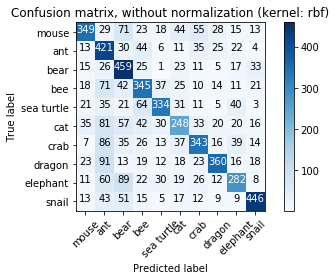

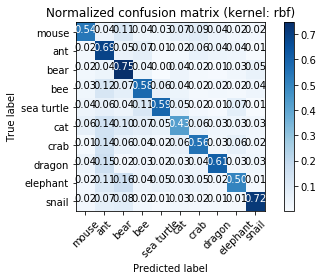

In [30]:
# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, yhat_svm2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix, without normalization (kernel: rbf)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (kernel: rbf)')

plt.show()

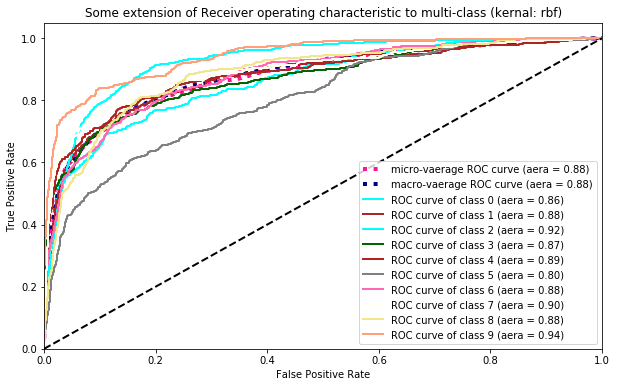

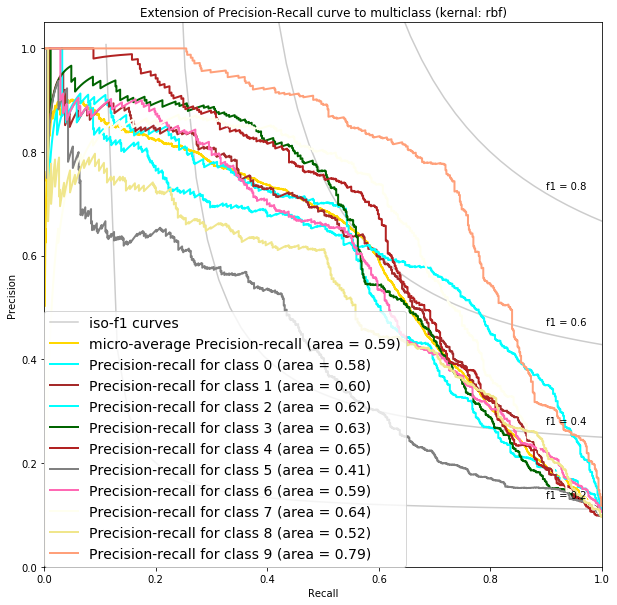

In [31]:
# plot ROC curve
plot_multiclass_roc(y_test_binary, y_score2,10,'rbf')

# plot PR curve
plot_multiclass_pr(y_test_binary,y_score2,10,'rbf')

### Sigmoid kernel

#### Grid Search with Cross Validation

In [19]:
# generate parameter space of C and Gamma
Gamma = np.array([0.01,0.05,0.1,0.5,1])
C = np.array([0.1,0.5,1,5,10])

# grid search with cross validation 
parameters = {'kernel':['sigmoid'], 'C':C, 'gamma': Gamma}
svm = svm.SVC()
gridsearch = GridSearchCV(estimator=svm,param_grid=parameters,n_jobs=1, verbose=2)
gridsearch.fit(X_train,y_train)
best_params = gridsearch.best_params_

In [22]:
print("Parameters:{}".format(parameters))
print("Best parameters:{}".format(best_params))

Parameters:{'kernel': ['sigmoid'], 'C': array([ 0.1,  0.5,  1. ,  5. , 10. ]), 'gamma': array([0.01, 0.05, 0.1 , 0.5 , 1.  ])}
Best parameters:{'kernel': ['sigmoid'], 'C': 0.1, 'gamma': 0.01}


#### Use best parameters to fit the model and show the results  (confusion matrix and classification report)

In [35]:
# fit the model with C = 0.1, gamma = 0.01, kernel = sigmoid
svm_model3 = svm.SVC(kernel = 'sigmoid',C = 0.1, coef0 = 0.0, gamma = 0.01)
svm_model3.fit(X_train,y_train)
yhat_svm3 = svm_model3.predict(X_test)
y_score3 = svm_model3.decision_function(X_test)

In [36]:
# print the result
print("Classification report for classifier %s:\n%s\n"
      % (svm_model3, metrics.classification_report(y_test, yhat_svm3)))
print("Accuracy={}".format(metrics.accuracy_score(y_test, yhat_svm3)))

Classification report for classifier SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.35      0.36      0.35       645
        1.0       0.44      0.53      0.48       611
        2.0       0.45      0.60      0.51       615
        3.0       0.49      0.34      0.40       594
        4.0       0.51      0.52      0.52       565
        5.0       0.28      0.27      0.28       582
        6.0       0.47      0.35      0.40       616
        7.0       0.69      0.55      0.62       593
        8.0       0.31      0.34      0.32       559
        9.0       0.51      0.57      0.54       620

avg / total       0.45      0.44      0.44      6000


Accuracy=0.44416666666666665


Confusion matrix, without normalization
[[232  18  58  17  46 115  43  28  29  59]
 [ 17 324  45  54  25  16  39  19  53  19]
 [ 39  19 369  17  10  42  12   4  32  71]
 [ 41  67  66 203  71  21  17  10  51  47]
 [ 60  20  26  40 296  38  14   7  52  12]
 [120  60  43  24  41 159  20  24  59  32]
 [ 44  62  33  15  14  59 215  27  84  63]
 [ 45  77  14  15  28  16  26 328  24  20]
 [ 29  68  83  22  28  71  39  16 188  15]
 [ 45  23  84   8  20  23  31   9  26 351]]
Normalized confusion matrix
[[0.36 0.03 0.09 0.03 0.07 0.18 0.07 0.04 0.04 0.09]
 [0.03 0.53 0.07 0.09 0.04 0.03 0.06 0.03 0.09 0.03]
 [0.06 0.03 0.6  0.03 0.02 0.07 0.02 0.01 0.05 0.12]
 [0.07 0.11 0.11 0.34 0.12 0.04 0.03 0.02 0.09 0.08]
 [0.11 0.04 0.05 0.07 0.52 0.07 0.02 0.01 0.09 0.02]
 [0.21 0.1  0.07 0.04 0.07 0.27 0.03 0.04 0.1  0.05]
 [0.07 0.1  0.05 0.02 0.02 0.1  0.35 0.04 0.14 0.1 ]
 [0.08 0.13 0.02 0.03 0.05 0.03 0.04 0.55 0.04 0.03]
 [0.05 0.12 0.15 0.04 0.05 0.13 0.07 0.03 0.34 0.03]
 [0.07 0.04 0.14 0.01 0.

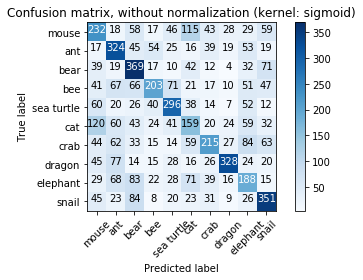

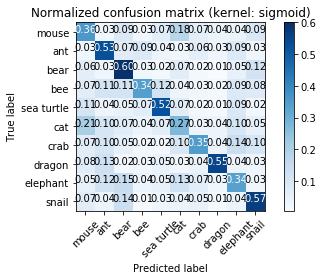

In [37]:
# Compute confusion matrix
cnf_matrix3 = confusion_matrix(y_test, yhat_svm3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names,
                      title='Confusion matrix, without normalization (kernel: sigmoid)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (kernel: sigmoid)')

plt.show()

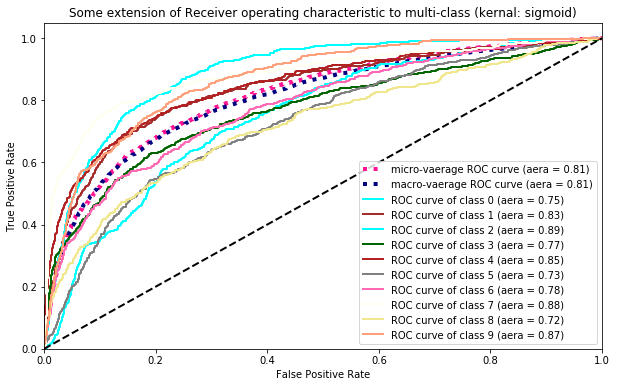

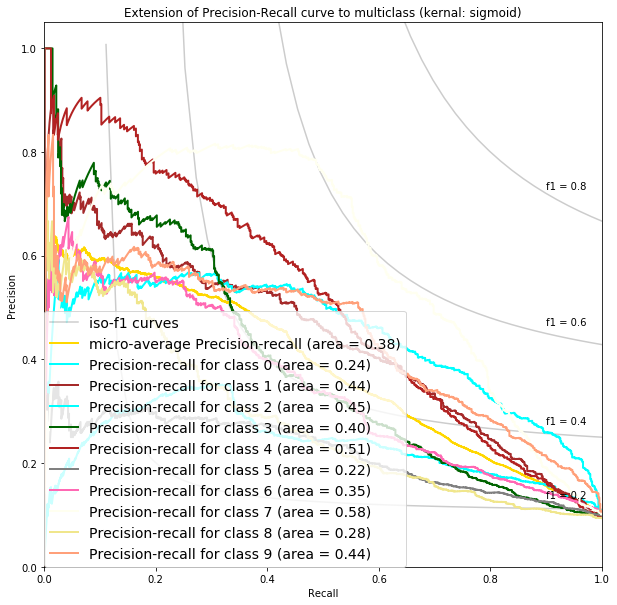

In [38]:
# plot ROC curve
plot_multiclass_roc(y_test_binary, y_score3,10,'sigmoid')

# plot PR curve
plot_multiclass_pr(y_test_binary,y_score3,10,'sigmoid')